# Intraday Strategy, Part 2: Model Training & Signal Evaluation

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and use the features engineered in the last notebook to train gradient boosting model that predicts the returns for the NASDAQ100 stocks over the next 1-minute bar. 

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact. This does certainly not reflect market reality, and is rather due to the challenges of simulating a trading strategy at this much higher intraday frequency in a realistic manner using open-source tools.

Note also that this section has slightly changed from the version published in the book to permit replication using the Algoseek data sample.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import sys, os
from pathlib import Path
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
print("Success")

Success


Ensuring we can import `utils.py` in the repo's root directory:

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [5]:
# where we stored the features engineered in the previous notebook
data_store = 'data/algoseek.h5'

In [6]:
# where we'll store the model results
result_store = 'data/intra_day.h5'

In [7]:
# here we save the trained models
model_path = Path('models/intraday')
if not model_path.exists():
    model_path.mkdir(parents=True)

## Load Model Data

In [12]:
#data = pd.read_hdf(data_store, 'model_data2')
#print(data)

data = pd.read_csv('Hennes_Mauritz_1_min_data.csv')  
data = data.set_index('DATETIME')
data = data.rename(columns={"RATE": "close"})
data['returns'] = data['close'].pct_change().shift(periods=-1)
data = data.dropna()
print(data)

                       open    high     low  QUANTITY        1        2  \
DATETIME                                                                  
2022-02-17 09:58:00  177.16  177.16  177.11      -532   -532.0   -326.0   
2022-02-17 09:59:00  177.14  177.18  176.96       641    641.0    109.0   
2022-02-17 10:00:00  177.08  177.17  177.08      -282   -282.0    359.0   
2022-02-17 10:01:00  177.20  177.23  177.20      -894   -894.0  -1176.0   
2022-02-17 10:02:00  177.08  177.17  177.06      -415   -415.0  -1309.0   
...                     ...     ...     ...       ...      ...      ...   
2022-06-17 17:08:00  124.28  124.44  124.14     26251  26251.0  28212.0   
2022-06-17 17:09:00  124.43  124.49  124.43       165    165.0  26416.0   
2022-06-17 17:10:00  124.49  124.50  124.23    -16664 -16664.0 -16499.0   
2022-06-17 17:11:00  124.24  124.24  124.15    -10984 -10984.0 -27648.0   
2022-06-17 17:12:00  124.14  124.14  124.06     -6316  -6316.0 -17300.0   

                        

In [65]:
# Pearson correlation coefficient
from scipy.stats.stats import pearsonr

for feature in range(1, 60):
    result = pearsonr(data[str(feature)], data['returns'])
    if result[1] <= 0.05:
        print("Feature", feature, "Pearson correlation coefficient", result[0], "Two-tailed p-value", result[1])
        
print("Feature IBS", "Pearson correlation coefficient", pearsonr(data['IBS'], data['returns'])[0], "Two-tailed p-value", pearsonr(data['IBS'], data['returns'])[1])

Feature 18 Pearson correlation coefficient -0.012492118031303123 Two-tailed p-value 0.02592169742687823
Feature 19 Pearson correlation coefficient -0.012856997899494186 Two-tailed p-value 0.02187984232394567
Feature 20 Pearson correlation coefficient -0.013190073092257944 Two-tailed p-value 0.018680762441705
Feature 21 Pearson correlation coefficient -0.012506293839608842 Two-tailed p-value 0.025753375856422997
Feature 39 Pearson correlation coefficient -0.01134401274103049 Two-tailed p-value 0.04310838606440898
Feature 40 Pearson correlation coefficient -0.011362567006357535 Two-tailed p-value 0.042768186832461814
Feature 41 Pearson correlation coefficient -0.011155074802862382 Two-tailed p-value 0.046704709493054025
Feature IBS Pearson correlation coefficient 0.0006552030066886612 Two-tailed p-value 0.9070025719868543


In [64]:
# https://www.datatechnotes.com/2020/09/regression-example-with-randomforestregressor.html
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X = data.drop(['returns'], axis=1)
y = data['returns']

# Feature importances with a forest of trees
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

from sklearn.ensemble import RandomForestRegressor
feature_names = list(data.columns.values)

#regr = RandomForestRegressor(max_depth=2, random_state=0)
regr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

regr.fit(X_train, y_train)

score = regr.score(X_train, y_train)
print("R-squared:", score) 

score = regr.score(X_test, y_test)
print("R-squared:", score) 

R-squared: 0.8479190038408633
R-squared: -0.052489618733419396


MSE:  1.2597471057132865e-06
RMSE:  6.298735528566433e-07


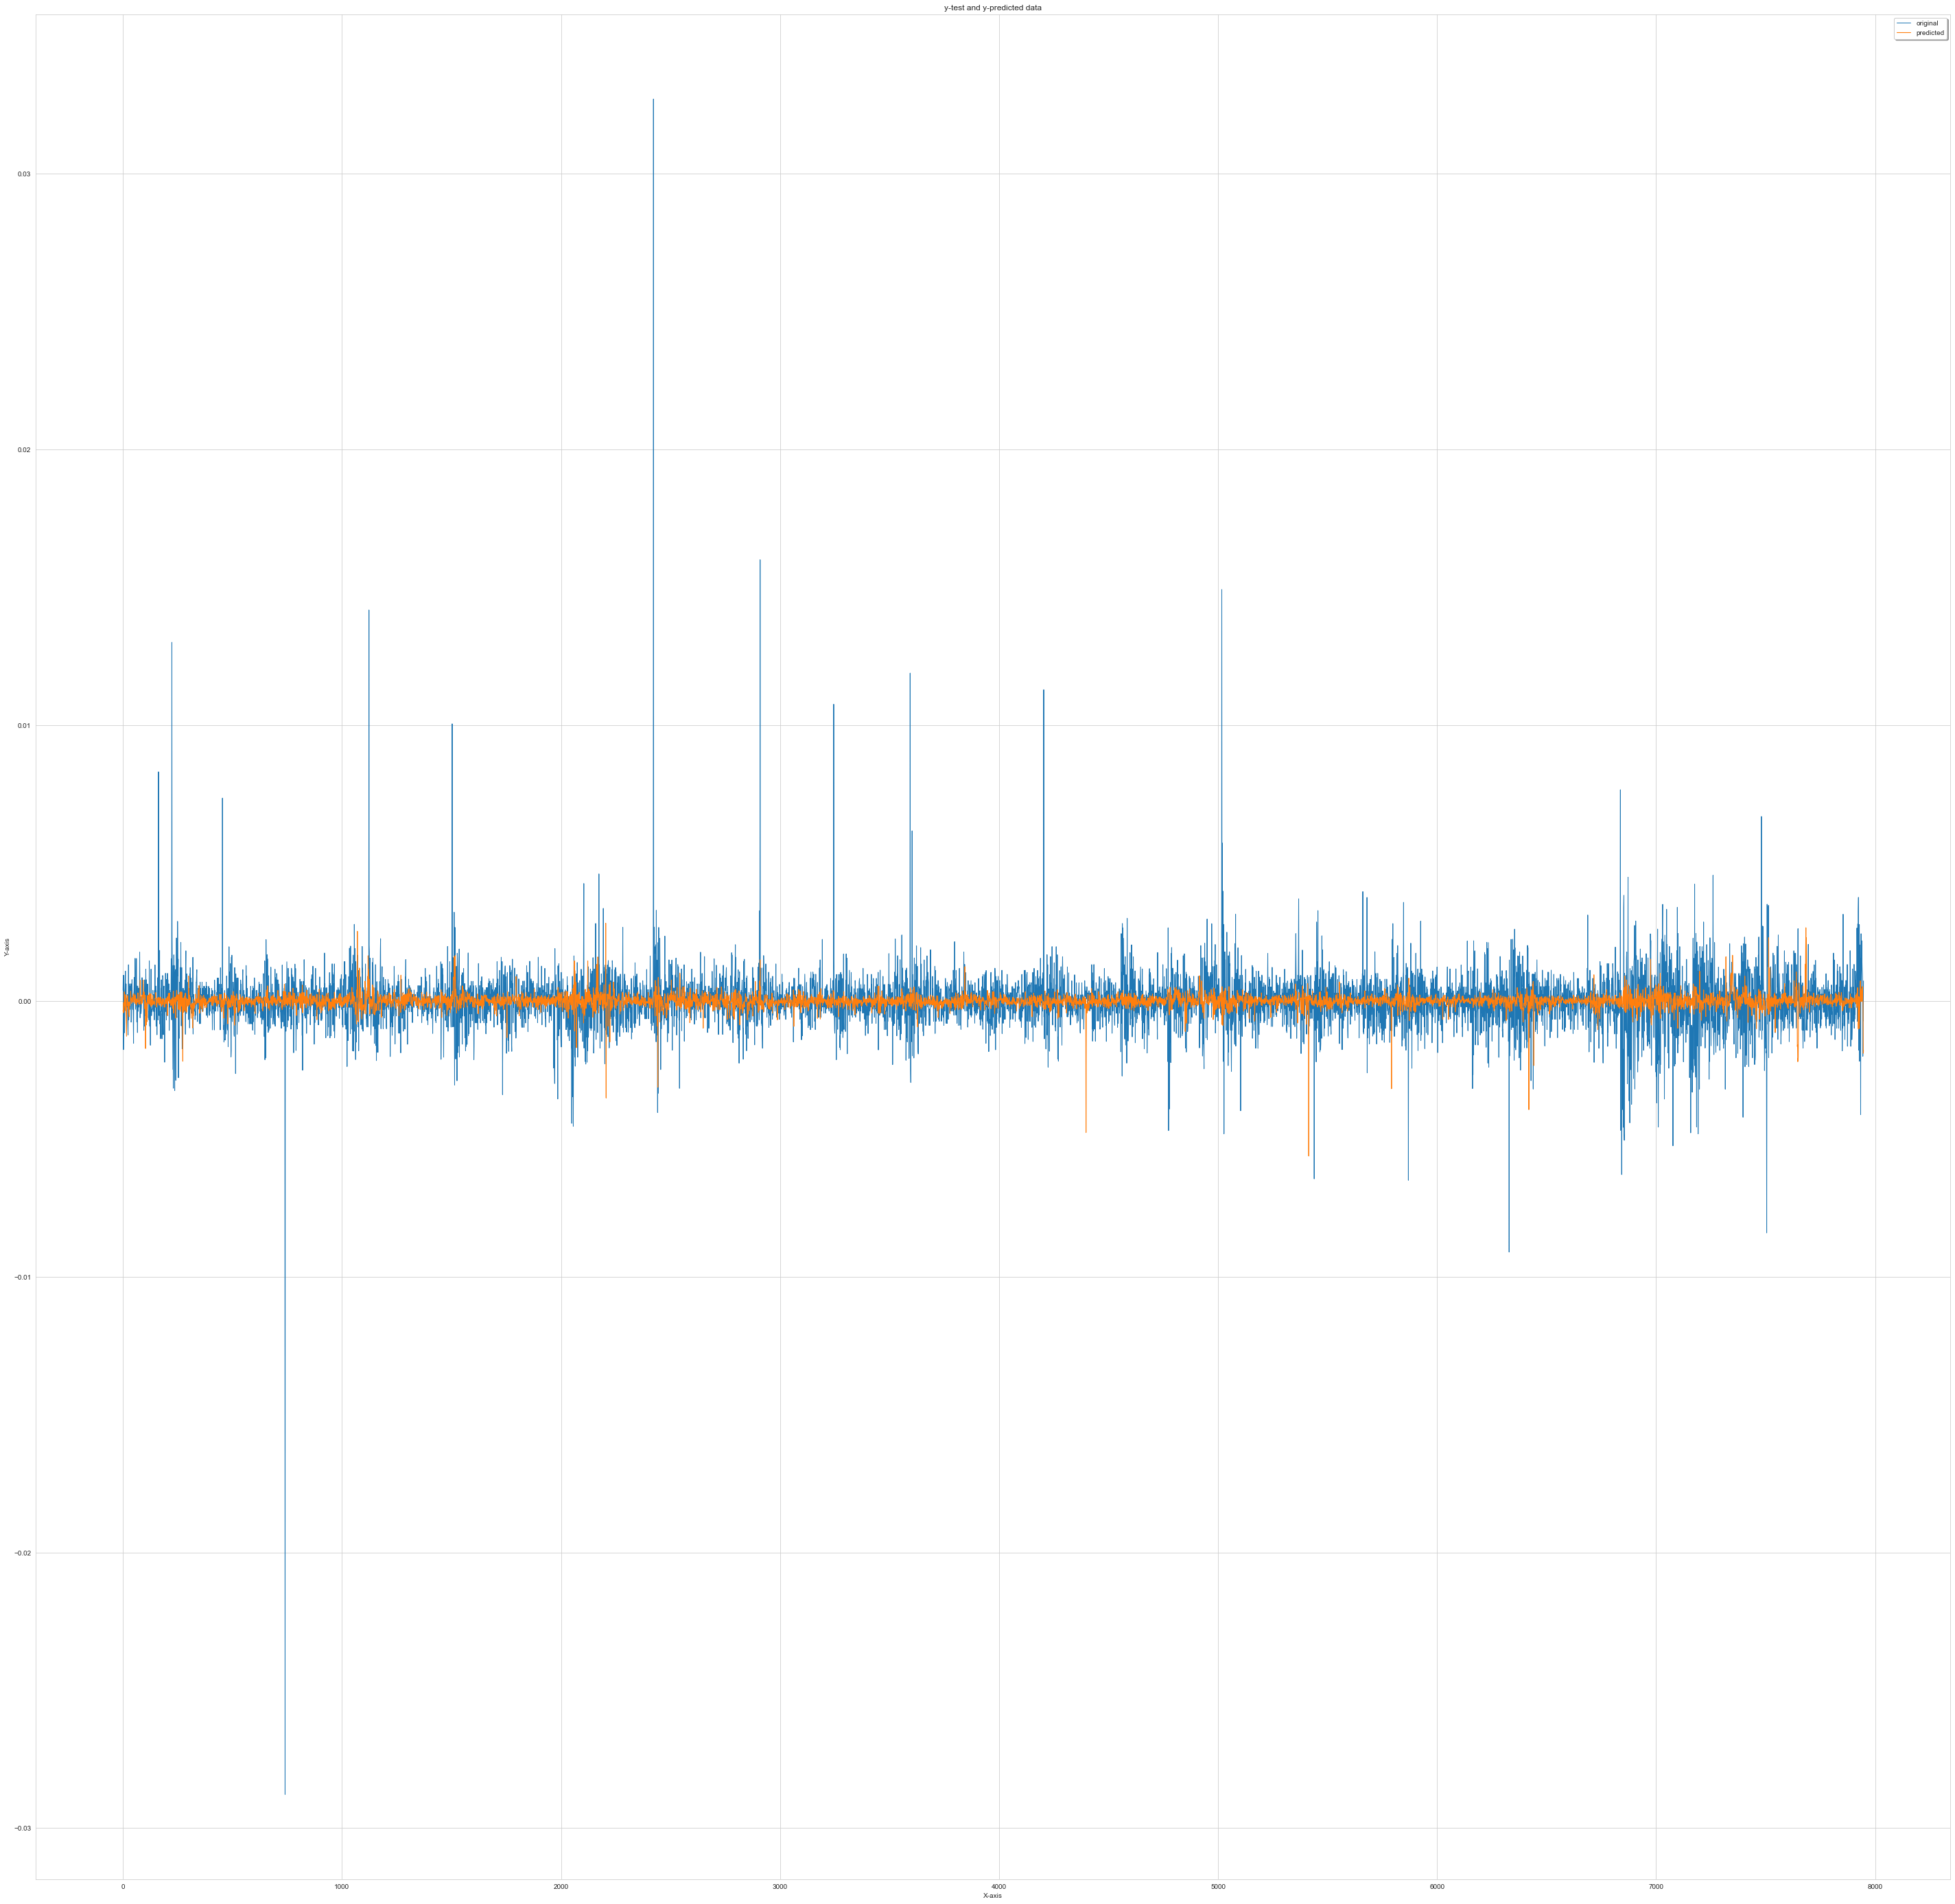

In [61]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



# Predicting and accuracy check
y_pred = regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
#plt.rcParams["figure.figsize"] = (50,50)
plt.show() 

In [23]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 31792 entries, 2022-02-17 09:58:00 to 2022-06-17 17:12:00
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      31792 non-null  float64
 1   high      31792 non-null  float64
 2   low       31792 non-null  float64
 3   QUANTITY  31792 non-null  int64  
 4   1         31792 non-null  float64
 5   2         31792 non-null  float64
 6   3         31792 non-null  float64
 7   4         31792 non-null  float64
 8   5         31792 non-null  float64
 9   6         31792 non-null  float64
 10  7         31792 non-null  float64
 11  8         31792 non-null  float64
 12  9         31792 non-null  float64
 13  10        31792 non-null  float64
 14  11        31792 non-null  float64
 15  12        31792 non-null  float64
 16  13        31792 non-null  float64
 17  14        31792 non-null  float64
 18  15        31792 non-null  float64
 19  16        31792 non-null  float64
 20  1

In [24]:
data.sample(frac=.1).describe(percentiles=np.arange(.1, 1, .1))

,open,high,low,QUANTITY,1,2,3,4,5,6,...,53,54,55,56,57,58,59,close,IBS,returns
count,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,...,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000
mean,138.154936,138.223696,138.085118,145.927965,145.927965,86.360491,-89.832652,29.203209,52.309531,35.462410,...,-1160.777603,-982.755898,-859.828562,-610.364580,-606.493237,-516.346021,-383.635420,138.154410,0.515523,0.000033
std,13.452032,13.459862,13.446106,11747.733740,11747.733740,16793.887801,21483.808038,24053.980188,26865.765614,28778.375831,...,90234.304333,91367.263604,92299.245392,93051.001898,93769.839061,95742.434793,96214.249793,13.453537,0.411295,0.001560
min,118.200000,118.200000,116.380000,-174084.000000,-174084.000000,-234571.000000,-522993.000000,-522484.000000,-520136.000000,-519709.000000,...,-604502.000000,-603829.000000,-606435.000000,-604769.000000,-602553.000000,-602316.000000,-602158.000000,116.380000,0.000000,-0.011747
10%,123.940000,124.000000,123.918000,-4928.800000,-4928.800000,-8490.000000,-11303.600000,-13705.600000,-15935.800000,-18181.600000,...,-88902.800000,-91233.800000,-90964.800000,-90057.800000,-91345.400000,-92279.600000,-91830.800000,123.956000,0.000000,-0.001073
20%,127.126000,127.206000,127.100000,-2304.400000,-2304.400000,-4334.800000,-5564.800000,-6936.600000,-8290.600000,-9622.200000,...,-46538.600000,-46417.800000,-46607.400000,-47514.400000,-47532.000000,-48455.600000,-48628.800000,127.170000,0.000000,-0.000631
30%,130.044000,130.092000,129.974000,-1201.800000,-1201.800000,-2307.200000,-2980.800000,-3632.800000,-4458.000000,-5111.600000,...,-26928.800000,-27083.000000,-27725.600000,-28041.200000,-28299.200000,-28092.000000,-28325.000000,130.054000,0.125000,-0.000355
40%,131.890000,131.960000,131.832000,-489.400000,-489.400000,-998.600000,-1289.000000,-1779.200000,-1954.400000,-2074.400000,...,-12741.600000,-12628.600000,-12696.200000,-13091.200000,-13296.000000,-13104.000000,-13106.600000,131.900000,0.333333,-0.000154
50%,135.300000,135.340000,135.270000,93.000000,93.000000,35.000000,43.000000,107.000000,264.000000,278.000000,...,840.000000,472.000000,695.000000,578.000000,275.000000,92.000000,655.000000,135.300000,0.538462,0.000000
60%,138.628000,138.698000,138.566000,671.800000,671.800000,968.200000,1470.200000,1811.000000,2044.600000,2792.200000,...,14308.600000,14107.000000,14434.800000,14646.200000,15303.800000,15436.600000,15779.400000,138.620000,0.747826,0.000156


## Model Training

### Helper functions

In [ ]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


In [ ]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Categorical Variables

In [ ]:
data['stock_id'] = pd.factorize(data.index.get_level_values('ticker'), sort=True)[0]

In [ ]:
categoricals = ['stock_id']

### Custom Metric

In [ ]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Cross-validation setup

In [ ]:
DAY = 390   # number of minute bars in a trading day of 6.5 hrs (9:30 - 15:59)
MONTH = 5 #20  # trading days

In [ ]:
def get_cv(n_splits=2):
    return MultipleTimeSeriesCV(n_splits=n_splits,
                                lookahead=1,
                                test_period_length=MONTH * DAY,       # test for 1 month
                                train_period_length=12 * MONTH * DAY,  # train for 1 year
                                date_idx='DATETIME')

Show train/validation periods:

In [ ]:
for i, (train_idx, test_idx) in enumerate(get_cv().split(X=data)):
    train_dates = data.iloc[train_idx].index.unique('DATETIME')
    test_dates = data.iloc[test_idx].index.unique('DATETIME')
    print(train_dates.min(), train_dates.max(), test_dates.min(), test_dates.max())

from sklearn.model_selection import train_test_split
X = data
y = data['returns']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)
for train, test in tscv.split(X):
    print("%s %s" % (train, test))

### Train model

In [ ]:
label = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(label).tolist()
label = label[0]

In [ ]:
params = dict(objective='regression',
              metric=['rmse'],
              device='gpu',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [ ]:
num_boost_round = 250

In [ ]:
cv = get_cv(n_splits=23) # we have enough data for 23 different test periods

In [ ]:
def get_scores(result):
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

The following model-training loop will take more than 10 hours to run and also consumes substantial memory. If you run into resource constraints, you can modify the code, e.g., by:
1. Only loading data required for one iteration.
2. Shortening the training period to require less than one year.

You can also speed up the process by using fewer `n_splits`, which implies longer test periods.

In [ ]:
start = time()
for train_idx, test_idx in tscv.split(X):
    # create lgb train set
    train_set = data.iloc[train_idx, :]
    lgb_train = lgb.Dataset(data=train_set.drop(label, axis=1),
                            label=train_set[label])
                            #,categorical_feature=categoricals)
    
    # create lgb test set
    test_set = data.iloc[test_idx, :]
    lgb_test = lgb.Dataset(data=test_set.drop(label, axis=1),
                           label=test_set[label],
                           #categorical_feature=categoricals, 
                           reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      evals_result=evals_result,
                      verbose_eval=50)
    model.save_model((model_path / f'{fold:02}.txt').as_posix())
    
    # get train/valid ic scores
    scores = get_scores(evals_result)
    scores.to_hdf(result_store, f'ic/{fold:02}')
    
    # get feature importance
    fi = get_fi(model)
    fi.to_hdf(result_store, f'fi/{fold:02}')
    
    # generate validation predictions
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, [label]]
    y_test['pred'] = model.predict(X_test)
    y_test.to_hdf(result_store, f'predictions/{fold:02}')
    
    # compute average IC per minute
    by_minute = y_test.groupby(test_set.index.get_level_values('date_time'))
    daily_ic = by_minute.apply(lambda x: spearmanr(x[label], x.pred)[0]).mean()
    print(f'\nFold: {fold:02} | {format_time(time()-start)} | IC per minute: {daily_ic:.2%}\n')

## Signal Evaluation

In [ ]:
with pd.HDFStore(result_store) as store:
    pred_keys = [k[1:] for k in store.keys() if k[1:].startswith('pred')]
    cv_predictions = pd.concat([store[k] for k in pred_keys]).sort_index()

In [ ]:
cv_predictions.info(null_counts=True)

In [ ]:
time_stamp = cv_predictions.index.get_level_values('date_time')
dates = sorted(np.unique(time_stamp.date))

We have out-of-sample predictions for 484 days from February 2016 through December 2017:

In [ ]:
print(f'# Days: {len(dates)} | First: {dates[0]} | Last: {dates[-1]}')

We only use minutes with at least 100 predictions:

In [ ]:
n = cv_predictions.groupby('date_time').size()

There are ~700 periods, equivalent to a bit over a single trading day (0.67% of all periods in the sample), with fewer than 100 predictions over the 23 test months:

In [ ]:
incomplete_minutes = n[n<100].index

In [ ]:
print(f'{len(incomplete_minutes)} ({len(incomplete_minutes)/len(n):.2%})')

In [ ]:
cv_predictions = cv_predictions[~time_stamp.isin(incomplete_minutes)]

In [ ]:
cv_predictions.info(null_counts=True)

### Information Coefficient

#### Across all periods

In [ ]:
ic = spearmanr(cv_predictions.fwd1min, cv_predictions.pred)[0]

#### By minute

We are making new predictions every minute, so it makes sense to look at the average performance across all short-term forecasts:

In [ ]:
minutes = cv_predictions.index.get_level_values('date_time')
by_minute = cv_predictions.groupby(minutes)

In [ ]:
ic_by_minute = by_minute.apply(lambda x: spearmanr(x.fwd1min, x.pred)[0])

minute_ic_mean = ic_by_minute.mean()
minute_ic_median = ic_by_minute.median()

print(f'\nAll periods: {ic:6.2%} | By Minute: {minute_ic_mean: 6.2%} (Median: {minute_ic_median: 6.2%})')

Plotted as a five-day rolling average, we see that the IC was mostly below the out-of-sample period mean, and increased during the last quarter of 2017 (as reflected in the validation results we observed while training the model).

In [ ]:
ax = ic_by_minute.rolling(5*650).mean().plot(figsize=(14, 5), title='IC (5-day MA)', rot=0)
ax.axhline(minute_ic_mean, ls='--', lw=1, c='k')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Information Coefficient')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Vectorized backtest of a naive strategey: financial performance by signal quantile

Alphalens does not work with minute-data, so we need to compute our own signal performance measures.

Unfortunately, Zipline's Pipeline also doesn't work for minute-data and Backtrader takes a very long time with such a large dataset. Hence, instead of an event-driven backtest of entry/exit rules as in previous examples, we can only create a rough sketch of the financial performance of a naive trading strategy driven by the model's predictions using vectorized backtesting (see Chapter 8 on the [ML4T workflow](../08_ml4t_workflow'). As we will see below, this does not produce particularly helpful results.

This naive strategy invests in equal-weighted portfolios of the stocks in each decile under the following assumptions (mentioned at the beginning of this notebook: 
1. Based on the predictions using inputs from the current and previous bars, we can enter positions at the first trade price in the following minute bar
2. We exit all positions at the last price in that following minute bar
3. There are no trading cost or market impact (slippage) of our trades (but we can check how sensitive the results would be).

#### Average returns by minute bar and signal quantile 

To this end, we compute the quintiles and deciles of the model's `fwd1min` predictions for each minute:

In [ ]:
by_minute = cv_predictions.groupby(minutes, group_keys=False)

In [ ]:
labels = list(range(1, 6))
cv_predictions['quintile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=5, labels=labels).astype(int))

In [ ]:
labels = list(range(1, 11))
cv_predictions['decile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=10, labels=labels).astype(int))

In [ ]:
cv_predictions.info(show_counts=True)

#### Descriptive statistics of intraday returns by quintile and decile of model predictions

Next, we compute the average one-minute returns for each quintile / decile and minute.

In [ ]:
def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
    by_quantile = cv_predictions.reset_index().groupby(['date_time', quantile])
    return by_quantile.fwd1min.mean().unstack(quantile).sort_index()

In [ ]:
intraday_returns = {'quintile': compute_intraday_returns_by_quantile(cv_predictions),
                    'decile': compute_intraday_returns_by_quantile(cv_predictions, quantile='decile')}

In [ ]:
def summarize_intraday_returns(returns):
    summary = returns.describe(deciles)
    return pd.concat([summary.iloc[:1].applymap(lambda x: f'{x:,.0f}'),
                      summary.iloc[1:].applymap(lambda x: f'{x:.4%}')])

The returns per minute, averaged over the 23-months period, increase by quintile/decile and range from -.3 (-.4) to .27 (.37) basis points for the bottom and top quintile (decile), respectively. While this aligns with the finding of a weakly positive rank correlation coefficient, it also suggests that such small gains are unlikely to survive the impact of trading costs.

In [ ]:
summary = summarize_intraday_returns(intraday_returns['quintile'])
summary

In [ ]:
summary = summarize_intraday_returns(intraday_returns['decile'])
summary

#### Cumulative Performance by Quantile

To simulate the performance of our naive strategy that trades all available stocks every minute, we simply assume that we can reinvest (including potential gains/losses) every minute. To check for the sensitivity with respect for trading cost, we can assume they are a constant number (fraction) of basis points, and subtract this number from the minute-bar returns.

In [ ]:
def plot_cumulative_performance(returns, quantile='quintile', trading_costs_bp=0):
    """Plot average return by quantile (in bp) as well as cumulative return, 
        both net of trading costs (provided as basis points; 1bp = 0.01%) 
    """

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

    sns.barplot(y='fwd1min', x=quantile,
                data=returns[quantile].mul(10000).sub(trading_costs_bp).stack().to_frame(
                    'fwd1min').reset_index(),
                ax=axes[0])
    axes[0].set_title(f'Avg. 1-min Return by Signal {quantile.capitalize()}')
    axes[0].set_ylabel('Return (bps)')
    axes[0].set_xlabel(quantile.capitalize())

    title = f'Cumulative Return by Signal {quantile.capitalize()}'
    (returns[quantile].sort_index().add(1).sub(trading_costs_bp/10000).cumprod().sub(1)
     .plot(ax=axes[1], title=title))

    axes[1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Return')
    fig.suptitle(f'Average and Cumulative Performance (Net of Trading Cost: {trading_costs_bp:.2f}bp)')

    sns.despine()
    fig.tight_layout()

Without trading costs, the compounding of even fairly small gains leads to extremely large cumulative profits for the top quantile. However, these disappear as soon as we allow for minuscule trading costs that reduce the average quantile return close to zero.

##### Without trading costs

In [ ]:
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=0)

In [ ]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=0)

##### With extremely low trading costs

In [ ]:
# assuming costs of a fraction of a basis point, close to the average return of the top quantile
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=.2)

In [ ]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=.3)

### Feature Importance

We'll take a quick look at the features that most contributed to improving the IC across the 23 folds:

In [ ]:
with pd.HDFStore(result_store) as store:
    fi_keys = [k[1:] for k in store.keys() if k[1:].startswith('fi')]
    fi = pd.concat([store[k].to_frame(i) for i, k in enumerate(fi_keys, 1)], axis=1)

The top features from a conventional feature importance perspective are the ticker, followed by NATR, minute of the day, latest 1m return and the CCI:

In [ ]:
fi.mean(1).nsmallest(25).plot.barh(figsize=(12, 8), title='LightGBM Feature Importance (gain)')
sns.despine()
plt.tight_layout();

Explore with greater accuracy and in more detail how feature values affect predictions using SHAP values as demonstrated in various other notebooks in this Chapter and the appendix!

## Conclusion

We have seen that a relatively simple gradient boosting model is able to achieve fairly consistent predictive performance that is significantly better than a random guess even on a very short horizon. 

However, the resulting economic gains of our naive strategy of frequently buying/(short-)selling the top/bottome quantiles are too small to overcome the inevitable transaction costs. On the one hand, this demonstrates the challenges of extracting value from a predictive signal. On the other hand, it shows that we need a more sophisticated backtesting platform so that we can even begin to design and evaluate a more sophisticated strategy that requires far fewer trades to exploit the signal in our ML predictions. 

In addition, we would also want to work on improving the model by adding more informative feature, e.g. based on the quote/trade info contained in the Algoseek data, or by fine-tuning our model architecture and hyperparameter settings.